## Settings

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score , recall_score

# Path to the dataset
train_path = './assets/train/'
test_path = './assets/test/'

# Feature extractor (SIFT)
sift = cv2.SIFT_create(contrastThreshold=0.01)

ModuleNotFoundError: No module named 'cv2'

### Create Descriptors

In [1]:
def extract_descriptors_from_image(image_path):
    """
    Extract exactly a specified number of descriptors from an image using SIFT.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or invalid: {image_path}")
    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None or len(descriptors) == 0:
        raise ValueError(f"No descriptors found in image: {image_path}")

    return descriptors

In [2]:
def collect_descriptors_all(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        num_des_class = 0
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    
                    # Append descriptors and corresponding labels
                    all_descriptors += descriptors.tolist()
                    all_labels += [i]*len(descriptors)
                    num_des_class += len(descriptors)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
        num_des_tot += num_des_class
        num_des_class_dist.append(num_des_class)
    print(f'total number of descriptors: {num_des_tot}')
    print(f'number of descriptors per class: {num_des_class_dist}')
    
    # Convert to NumPy arrays
    all_descriptors = np.array(all_descriptors)
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels

In [3]:
def collect_descriptors_with_labels(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    all_descriptors.append(descriptors.tolist())
                    all_labels.append(i)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
    
    # Convert to NumPy arrays
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels

In [6]:
# Extract descriptors and labels
descriptors_pool, labels_pool = collect_descriptors_all(train_path)

print("Descriptor extraction completed.")

total number of descriptors: 104008
number of descriptors per class: [13465, 15119, 5421, 8680, 10758, 14686, 18524, 8025, 2550, 6780]
Descriptor extraction completed.


# Q1. K-means codebook

### Construct K-Means codebook

In [4]:
# Number of clusters (k)
k = 15

start_time = time.perf_counter()

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
kmeans.fit(descriptors_pool)

codebook_cons_time = time.perf_counter() - start_time

print(f'time for codebook construction time: {codebook_cons_time}')

# Access cluster centers and labels
k_means_codebook = kmeans.cluster_centers_  # Shape: (k, 128)
labels = kmeans.labels_  # Shape: (104008,)

NameError: name 'time' is not defined

In [53]:
def create_bow_histogram(img_descriptors, kmeans):
    # Predict the closest cluster for each descriptor
    labels = kmeans.predict(img_descriptors)  # This gives the cluster index for each descriptor
    
    k = kmeans.n_clusters
    img_bow = np.zeros(k)

    for label in labels:
        img_bow[label] += 1
    
    # Normalize the histogram to get a normalized BoW representation
    img_bow = img_bow / np.sum(img_bow)  # Normalize to make it a probability distribution
    return img_bow
    # return labels

### Apply K-means codebook for train/test data

In [54]:
# Extract train descriptors and labels
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()

train_bow = []
for descriptors in train_descriptors:
    image_bow = create_bow_histogram(descriptors, kmeans)
    train_bow.append(image_bow)

train_bow = np.array(train_bow)

vq_time = time.perf_counter() - start_time
print(f'vector quantization time for train data: {vq_time}')

x_train = train_bow
y_train = train_labels

Descriptor extraction completed.
vector quantization time for train data: 0.4969416999956593


In [55]:
x_train[-1]

array([0.00771388, 0.04908836, 0.11851332, 0.01192146, 0.0371669 ,
       0.10869565, 0.03927069, 0.03997195, 0.05539972, 0.23071529,
       0.01402525, 0.09046283, 0.00140252, 0.17601683, 0.01963534])

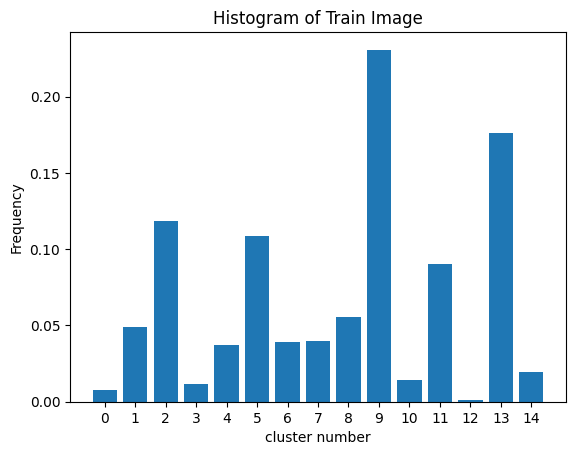

In [60]:
# Plot the histogram
x_axis = np.arange(len(x_train[-1]))
plt.bar(x_axis, x_train[-1])
plt.title('Histogram of Train Image')
plt.xlabel('cluster number')
plt.xticks(x_axis)
plt.ylabel('Frequency')
plt.show()

In [14]:
# Extract test descriptors and labels
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()

test_bow = []
for descriptors in test_descriptors:
    image_bow = create_bow_histogram(descriptors, kmeans)
    test_bow.append(image_bow)

test_bow = np.array(test_bow)

vq_time = time.perf_counter() - start_time
print(f'vector quantization time for test data: {vq_time}')

x_test = test_bow
y_test = test_labels

Descriptor extraction completed.
vector quantization time for test data: 0.44601300003705546


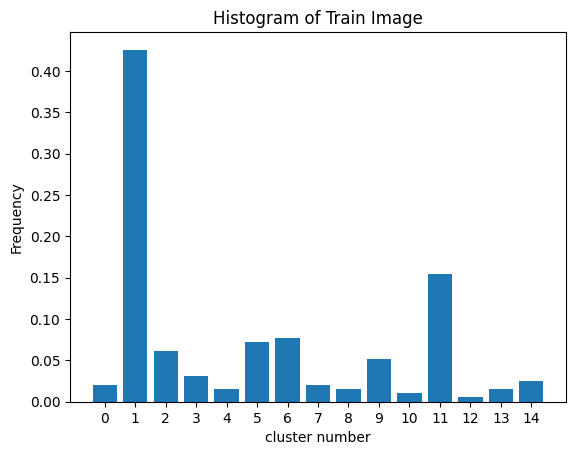

In [61]:
# Plot the histogram
x_axis = np.arange(len(x_test[-1]))
plt.bar(x_axis, x_test[-1])
plt.title('Histogram of Train Image')
plt.xlabel('cluster number')
plt.xticks(x_axis)
plt.ylabel('Frequency')
plt.show()

# Q2. RF classifier

In [10]:
def RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy'):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_train_pred = rf_clf.predict(x_train)

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_test_pred = rf_clf.predict(x_test)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

### Weak learner: Axis-aligned test

In [11]:
y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')

train_accuracy = accuracy_score(y_train.T, y_train_pred)
test_accuracy = accuracy_score(y_test.T, y_test_pred)
test_precision = precision_score(y_test.T, y_test_pred, average= "macro", zero_division=0)
test_recall = recall_score(y_test.T, y_test_pred, average= "macro", zero_division=0)

print(f'train time: {train_time}')
print(f'train accuracy: {train_accuracy}')
print('\n')

print(f'test time: {test_time}')
print(f'test_accuracy: {test_accuracy}')
print('\n')

print(f'test_precision: {test_precision}')
print(f'test_recall: {test_recall}')
print('\n')

print(f'max tree depth: {max_tree_depth}')

train time: 0.1911473000072874
train accuracy: 0.9733333333333334


test time: 0.004937999998219311
test_accuracy: 0.46


test_precision: 0.45568392134181607
test_recall: 0.45999999999999996


max tree depth: 5


### Weak learner: Two-pixel test

In [12]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix.T, x_test_2pix.T

In [13]:
n_pairs = x_train.shape[1]
# n_pairs = 100
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train.T, x_test.T, n_pairs=n_pairs, random_seed=0)
y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, n_estimators=30, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')

train_accuracy = accuracy_score(y_train.T, y_train_pred)
test_accuracy = accuracy_score(y_test.T, y_test_pred)
test_precision = precision_score(y_test.T, y_test_pred, average= "macro", zero_division=0)
test_recall = recall_score(y_test.T, y_test_pred, average= "macro", zero_division=0)

print(f'train time: {train_time}')
print(f'train accuracy: {train_accuracy}')
print('\n')

print(f'test time: {test_time}')
print(f'test_accuracy: {test_accuracy}')
print('\n')

print(f'test_precision: {test_precision}')
print(f'test_recall: {test_recall}')
print('\n')

print(f'max tree depth: {max_tree_depth}')

train time: 0.19790070003364235
train accuracy: 0.9933333333333333


test time: 0.002572300028987229
test_accuracy: 0.35333333333333333


test_precision: 0.34651667776667777
test_recall: 0.3533333333333334


max tree depth: 10
